In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def get_pickle_data(name):
    with open(f"{name}.pkl", "rb") as fr:
        data = pickle.load(fr)
    return data

In [ ]:
ROOT = '/content/drive/MyDrive/2021_BigData/'
img_root = ROOT + "data/train/"

In [ ]:
targetData = get_pickle_data(ROOT + 'data/new_scores')
data = pd.read_csv(ROOT+ 'data/train.csv')
target = pd.DataFrame(targetData)
target.head()

,0
0,2
1,3
2,2
3,3
4,1


In [ ]:
data.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,0,1,1,1,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,1,1,0,0
3,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0


In [ ]:
data = data.iloc[:6000]

In [ ]:
len(data)

6000

In [ ]:
data.drop('Pawpularity',axis=1, inplace=True)

In [ ]:
names= data.columns.tolist()

In [ ]:
names = np.array(names)

In [ ]:
print(names)

['Subject Focus' 'Eyes' 'Face' 'Near' 'Action' 'Accessory' 'Group'
 'Collage' 'Human' 'Occlusion' 'Info' 'Blur']


In [ ]:
data.drop('Id',axis=1, inplace=True)

In [ ]:
x_training, x_test, y_training, y_test = train_test_split(data, target, test_size=0.2,random_state=44)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# random forest에서 tree의 개수
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# 각 split에서 고려할 feature의 개수
max_features = ['auto', 'sqrt']
# tree의 최대 level 개수
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# node를 spilt할때 최소 개수
min_samples_split = [2, 5, 10]
# leaf node의 최소 개수
min_samples_leaf = [1, 2, 4]
# 각 tree를 학습시킬때 샘플을 선택하는 Method
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# 10 * 2* 12 * 3 * 3 * 2

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# best hyperparameters를 찾기 위한 random grid사용
rf = RandomForestRegressor()
# 3 fold cross validation을 사용한 parameter random search
# 100개의 다른 조합을 search, 사용가능한 코어 모두 사용
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# random search model fit 하기
rf_random.fit(x_training,  y_training)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400}

In [ ]:
from sklearn.metrics import mean_squared_error
# best hyperparameter를 적용한 모델 fit 하기
base_model = rf_random.best_estimator_
base_model.fit(x_training,  y_training)
# test set을 이용해 predict 하기
predictions = base_model.predict(x_test)
# mse 구하기
mse = mean_squared_error(y_test, predictions)
print(mse)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


0.9378776217010234


In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
mseOos = []
nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    maxFeat = 4 #조정해볼 것
    RFModel = ensemble.RandomForestRegressor(n_estimators=iTrees,
                    max_depth=depth, max_features=maxFeat,
                    oob_score=False, random_state=531)
    RFModel.fit(x_training, y_training)
    #데이터 세트에 대한 MSE 누적
    prediction = RFModel.predict(x_test)
    mseOos.append(mean_squared_error(y_test, prediction))
print("MSE")
print(mseOos)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/usr/local/lib/python3.7

MSE
[0.9557802366580177, 0.9554903739842875, 0.9553050724586277, 0.9558649308300805, 0.9555897242585979, 0.9554286699920038, 0.9556334507560799, 0.9550577358976703, 0.9550406660581772, 0.9550038160678722, 0.9550119728818109, 0.9552187692039092, 0.9551023273544001, 0.954975828352104, 0.9551256173115398, 0.9549616620252709, 0.9545480852846127, 0.9548413957920968, 0.9547951632131948, 0.9551684331854422, 0.9550806621406234, 0.9551260583917881, 0.955244897809683, 0.9553743135566648, 0.9553794844213487, 0.9554817996573532, 0.9555791364656046, 0.9554502470861765, 0.9557105821893792, 0.9558140037933254, 0.9557019535436457, 0.955566885037667, 0.9554930767816495, 0.9555029670899681, 0.9553470607241052, 0.9553105329998512, 0.9553615798739873, 0.955333945109541, 0.9551984374770245, 0.955264935508477, 0.955238919375372, 0.955188685749848, 0.9552133600938837, 0.9552797056088006, 0.9553144017862933]


In [ ]:
mseOos

[0.9557802366580177,
 0.9554903739842875,
 0.9553050724586277,
 0.9558649308300805,
 0.9555897242585979,
 0.9554286699920038,
 0.9556334507560799,
 0.9550577358976703,
 0.9550406660581772,
 0.9550038160678722,
 0.9550119728818109,
 0.9552187692039092,
 0.9551023273544001,
 0.954975828352104,
 0.9551256173115398,
 0.9549616620252709,
 0.9545480852846127,
 0.9548413957920968,
 0.9547951632131948,
 0.9551684331854422,
 0.9550806621406234,
 0.9551260583917881,
 0.955244897809683,
 0.9553743135566648,
 0.9553794844213487,
 0.9554817996573532,
 0.9555791364656046,
 0.9554502470861765,
 0.9557105821893792,
 0.9558140037933254,
 0.9557019535436457,
 0.955566885037667,
 0.9554930767816495,
 0.9555029670899681,
 0.9553470607241052,
 0.9553105329998512,
 0.9553615798739873,
 0.955333945109541,
 0.9551984374770245,
 0.955264935508477,
 0.955238919375372,
 0.955188685749848,
 0.9552133600938837,
 0.9552797056088006,
 0.9553144017862933]

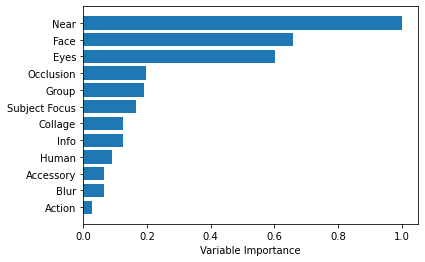

In [ ]:
import matplotlib.pyplot as plot

#피처 중요도 도표 그리기
featureImportance = base_model.feature_importances_

#가장 높은 중요도 기준으로 스케일링 -> max로 나눠서 값을 0~1 사이로 만들어줌
featureImportance = featureImportance/featureImportance.max()
# 큰 값으로 sort 하기
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
# plot을 사용해 그래프 그리기
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, names[sorted_idx])
plot.xlabel('Variable Importance')
plot.show()